In [1]:
import pandas as pd
import pymorphy2 as pm
import string
import matplotlib.pyplot as plt
import os
import io
import codecs
import numpy as np
import itertools
import xgboost as xgb
import operator
from pprint import pprint
from nltk.stem.snowball import SnowballStemmer
from keras.models import Sequential
from keras.layers import Dense
from functions import save_vars, load_vars

Using TensorFlow backend.


In [2]:
%matplotlib inline  
morph = pm.MorphAnalyzer()
stemmer = SnowballStemmer('russian')
ratings = pd.read_csv('ratings.csv')
ratings = list(ratings['0'])
POSES = ['noun', 'verb', 'adjf', 'adjs', 'npro']
PARAMS = POSES + ['word', 'unique']

In [3]:
counts = {i: list() for i in PARAMS}
ratios = {i: list() for i in POSES + ['unique']}
list_stem = list()
if {'counts.pickle', 'ratios.pickle'}.issubset(set(os.listdir('.'))):
    counts = load_vars(filename='counts.pickle')
    ratios = load_vars(filename='ratios.pickle')
else:
    for season in sorted(os.listdir('data')):
        print season
        if season[0] == '.':
            continue

        for episode in sorted(os.listdir('data/' + season)):
            if ('2x14' in episode
                    or '4x18' in episode
                    or '4x19' in episode
                    or '4x2' in episode
                    or '06x' in episode
                    or '07x' in episode
                    or 'S08E' in episode
                    or '09x' in episode
                    or 'S10E' in episode):
                f = io.open('data/' + season + '/' + episode, 'r')
            else:
                f = io.open('data/' + season + '/' + episode, 'r', encoding='cp1251')

            string_raw = f.read()
            list_raw = string_raw.split('\n')  # convert string to list
            list_without_num = [i for i in list_raw if i]  # remove empty items
            list_without_num = [i for i in list_without_num if not i[0].isdigit()]  # leave only text
            list_clear = [i.replace('<i>', '').replace('</i>', '') for i in list_without_num]  # replace <i>
            list_clear = [''.join([symbol for symbol in word if symbol not in string.punctuation]) for word in list_clear]  # replace punctuation
            list_words = [i.split(' ') for i in list_clear]  # !2d list!
            list_words = list(itertools.chain.from_iterable(list_words))  # flatten 2D list
            list_stem.append([stemmer.stem(i) for i in list_words if len(i) >= 3])
            parts_of_speech = [morph.parse(i)[0].tag.POS for i in list_words]

            counts_temp = {i: parts_of_speech.count(i.upper()) for i in POSES + ['infn']}
            counts_temp['verb'] += counts_temp['infn']
            counts_temp['unique'] = len(set([stemmer.stem(i) for i in list_words if len(i) >= 3]))
            del counts_temp['infn']
            counts_temp['word'] = len(parts_of_speech)
            counts = {i: counts[i] + [counts_temp[i]] for i in PARAMS}
            ratios = {i: ratios[i] + [counts_temp[i] / float(counts_temp['word'])] for i in POSES + ['unique']}

    save_vars(variable=counts, filename='counts.pickle')
    save_vars(variable=ratios, filename='ratios.pickle')

S01
S02
S03
S04
S05
S06
S07
S08
S09
S10


correlations for words and POS counts
[('noun', 0.2608024618077837),
 ('adjf', 0.10863776649716568),
 ('unique', 0.06176745196729032),
 ('adjs', 0.016605239129279168),
 ('word', -0.1616156327542195),
 ('npro', -0.2722022278735941),
 ('verb', -0.366859970658801)]


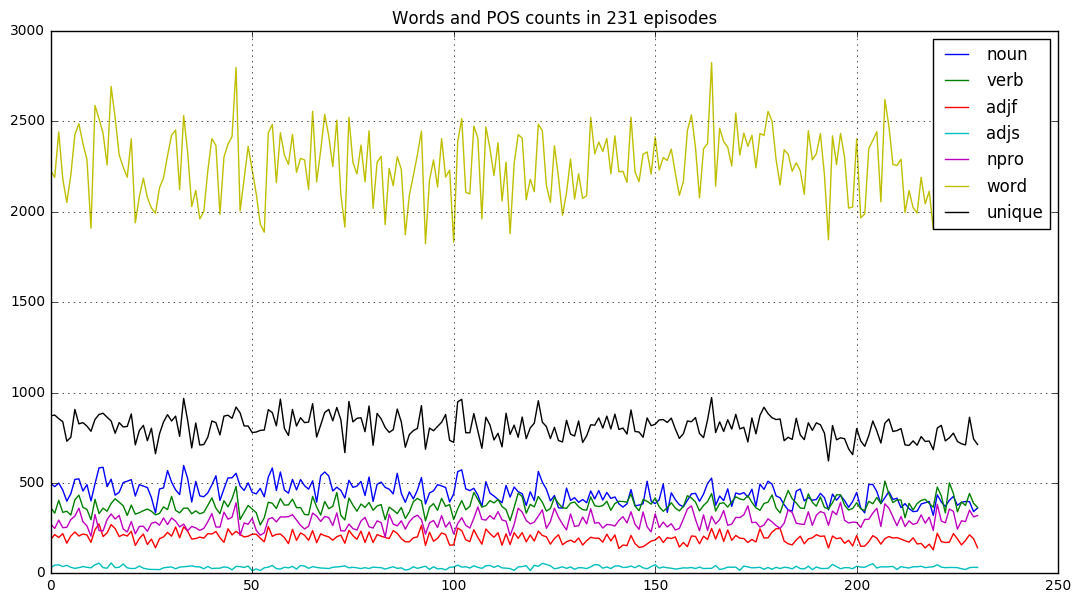

In [159]:
correlations = [(i, np.corrcoef(ratings, counts[i])[0][1]) for i in PARAMS]
print 'correlations for words and POS counts'
pprint(sorted(correlations, key=operator.itemgetter(1), reverse=True))
plt.figure(figsize=[13, 7])
plt.title('Words and POS counts in %s episodes' % len(ratings))
[plt.plot(counts[i], label=i) for i in PARAMS]
plt.legend()
plt.grid()

Correlations for POS ratios:
[('noun', 0.44033840864051976),
 ('unique', 0.292134853416421),
 ('adjf', 0.25387088281054515),
 ('adjs', 0.07215924900589726),
 ('npro', -0.22310787827136194),
 ('verb', -0.3421359305230505)]


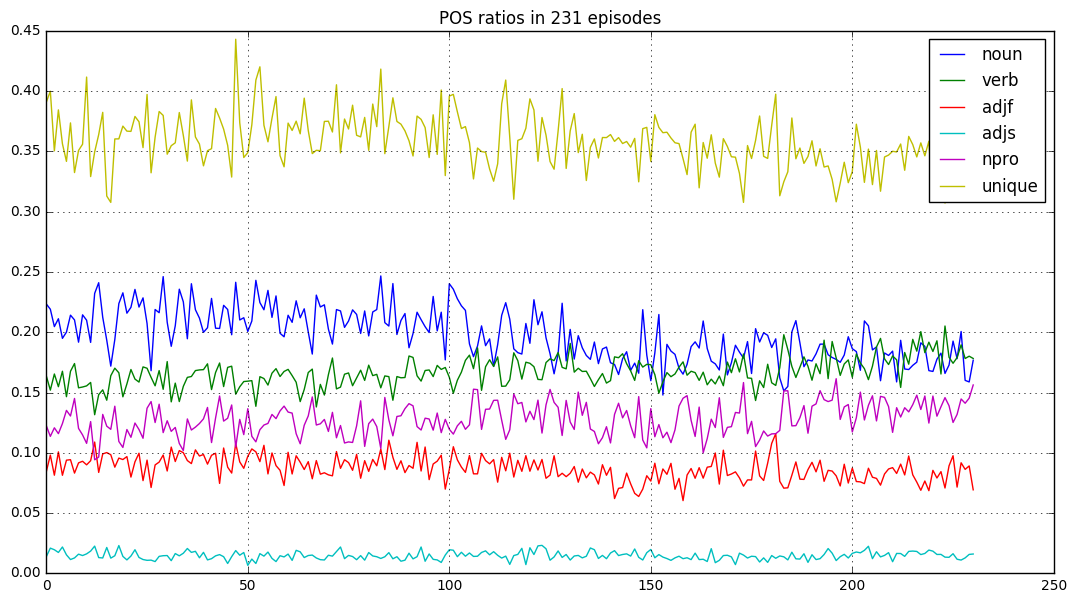

In [160]:
correlations = [(i, np.corrcoef(ratings, ratios[i])[0][1]) for i in POSES + ['unique']]
print 'Correlations for POS ratios:'
pprint(sorted(correlations, key=operator.itemgetter(1), reverse=True))
plt.figure(figsize=[13, 7])
plt.title('POS ratios in %s episodes' % len(ratings))
[plt.plot(ratios[i], label=i) for i in POSES + ['unique']]
plt.legend()
plt.grid()

In [55]:
training_parameters = ['noun_r', 'verb_r', 'adjf_r', 'adjs_r', 'unique_r', 'npro_r', 'noun_c', 'verb_c', 'adjf_c', 'adjs_c', 'npro_c', 'word']  # "r" - means ratio and "c" means count
for length in [i for i in range(1, 13, 1)]:
    combinations = list(itertools.combinations(training_parameters, length))
    for combination in combinations:
        x_all = list()
        for noun_r, verb_r, adjf_r, adjs_r, unique_r, npro_r, noun_c, verb_c, adjf_c, adjs_c, npro_c, word in zip(ratios['noun'], ratios['verb'], ratios['adjf'], ratios['adjs'], ratios['unique'], ratios['npro'], counts['noun'], counts['verb'], counts['adjf'], counts['adjs'], counts['npro'], counts['word']):
            temp = list()
            if 'noun_r' in combination:
                temp.append(noun_r)
            if 'verb_r' in combination:
                temp.append(verb_r)
            if 'adjf_r' in combination:
                temp.append(adjf_r)
            if 'adjs_r' in combination:
                temp.append(adjs_r)
            if 'npro_r' in combination:
                temp.append(npro_r)
            if 'unique_r' in combination:
                temp.append(unique_r)
            if 'noun_c' in combination:
                temp.append(noun_c)
            if 'verb_c' in combination:
                temp.append(verb_c)
            if 'adjf_c' in combination:
                temp.append(adjf_c)
            if 'adjs_c' in combination:
                temp.append(adjs_c)
            if 'npro_c' in combination:
                temp.append(npro_c)
            if 'word' in combination:
                temp.append(word)
            x_all.append(temp)

        x_train = x_all[:100] + x_all[150:]
        x_test = x_all[100:150]
        y_train = ratings[:100] + ratings[150:]
        y_test = ratings[100:150]
        model = xgb.XGBRegressor(max_depth=5)
        model.fit(x_train, y_train)
        y_predicted = model.predict(x_test)
        if np.corrcoef(y_test, y_predicted)[0][1] > 0.3:
            print np.corrcoef(y_test, y_predicted)[0][1], combination

0.35633535362945673 ('adjs_r', 'unique_r')
0.3097551709114301 ('npro_r', 'adjf_c')
0.3011302676445684 ('npro_r', 'word')
0.353141085545642 ('unique_r', 'verb_c', 'adjf_c')
0.3247663224856903 ('adjs_r', 'npro_r', 'adjs_c', 'word')
0.32346803699949933 ('unique_r', 'npro_r', 'noun_c', 'adjs_c', 'npro_c')
